In [1]:
# ----------------------------------------
# 1. GPU 屏蔽设置(对于两块适配不同cuada版本gpu使用，此部分可删去)
# ----------------------------------------

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
# ----------------------------------------
# 2. 导入库并检查环境
# ----------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import time
import numpy as np
import matplotlib.pyplot as plt

# 导入 SpikingJelly 核心库
from spikingjelly.activation_based import neuron, functional, layer

# 导入 CIFAR10-DVS 数据集加载器
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS

# 导入 自定义的替代梯度函数
import my_surrogates

# 检查环境 (与 run_cifar10_snn 相同)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.get_device_name(0)}")
    print(f"Device count: {torch.cuda.device_count()}")

PyTorch version: 2.9.1+cu128
CUDA available: True
Current device: NVIDIA GeForce RTX 3090
Device count: 1


In [4]:
# ----------------------------------------
# 3. 定义超参数和设置
# ----------------------------------------
import tonic
import torchvision.transforms as transforms

# === 关键设置 ===
SLICE_MODE = 'count' # 'time' 或 'count'

# 仿真参数
T = 10            
BATCH_SIZE = 16   
EPOCHS = 100      

# 核心修改：设置学习率
# SuperSpike 通常在 1e-3 表现较好
LR = 1e-3         

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"设置: Mode={SLICE_MODE}, T={T}, Batch={BATCH_SIZE}, LR={LR}, Device={DEVICE}")

设置: Mode=count, T=10, Batch=16, LR=0.001, Device=cuda


In [5]:
# ----------------------------------------
# 4. 加载、预处理及划分 CIFAR10-DVS 数据集 (修复版)
# ----------------------------------------
from torch.utils.data import random_split
import os

print(f"正在构建数据集 (切分模式: {SLICE_MODE})...")

sensor_size = tonic.datasets.CIFAR10DVS.sensor_size

# 1. 根据模式定义 ToFrame 变换
if SLICE_MODE == 'time':
    to_frame_transform = tonic.transforms.ToFrame(
        sensor_size=sensor_size, 
        n_time_bins=T
    )
elif SLICE_MODE == 'count':
    to_frame_transform = tonic.transforms.ToFrame(
        sensor_size=sensor_size, 
        n_event_bins=T
    )
else:
    raise ValueError("SLICE_MODE must be 'time' or 'count'")

# 2. 定义组合变换 (修复 dtype 问题)
# 使用 lambda 表达式进行类型转换，这是最稳妥的方法
transform = tonic.transforms.Compose([
    to_frame_transform,
    torch.from_numpy,
    transforms.Lambda(lambda x: x.float()) # 替代 tonic.transforms.dtype
])

# 定义数据集根目录
data_root = './'

# 3. 加载完整数据集 (CIFAR10-DVS 不区分 train/test，需手动划分)
print("正在加载完整数据集索引...")
full_dataset_raw = tonic.datasets.CIFAR10DVS(save_to=data_root, transform=transform)

# 4. 启用磁盘缓存 (Disk Cache)
# 建议在划分之前对整个数据集加缓存，这样无论怎么划分，缓存文件都是通用的
cache_path = f'./cache/cifar10dvs/{SLICE_MODE}'
if not os.path.exists(cache_path):
    os.makedirs(cache_path)

print(f"启用磁盘缓存 -> {cache_path}")
print("注意：缓存文件将在读取数据时生成 (Lazy Loading)，初始文件夹可能为空。")
cached_full_dataset = tonic.DiskCachedDataset(full_dataset_raw, cache_path=cache_path)

# 5. 手动划分训练集和测试集 (例如 90% 训练, 10% 测试)
# CIFAR10-DVS 共 10,000 张图
train_size = int(0.9 * len(cached_full_dataset))
test_size = len(cached_full_dataset) - train_size

print(f"正在随机划分数据集: 训练集 {train_size} / 测试集 {test_size}")
# 固定随机种子以保证每次运行划分一致（可选）
generator = torch.Generator().manual_seed(42)
train_set, test_set = random_split(cached_full_dataset, [train_size, test_size], generator=generator)

# 6. 创建 DataLoader
# drop_last=True 防止最后一个 batch 尺寸不一致导致 BatchNorm 报错
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)

print("DataLoader 构建完成。")

# --- 预热缓存 (可选) ---
# 为了让你看到缓存文件生成，我们可以尝试读取第一个 batch
print("正在尝试读取一个 Batch 以触发缓存生成 (请稍候)...")
try:
    first_batch = next(iter(train_loader))
    print(f"预读取成功！数据形状: {first_batch[0].shape}")
    print(f"现在查看 {cache_path} 文件夹，应该能看到部分 .bin 文件生成了。")
except Exception as e:
    print(f"预读取警告: {e}")

正在构建数据集 (切分模式: count)...
正在加载完整数据集索引...
启用磁盘缓存 -> ./cache/cifar10dvs/count
注意：缓存文件将在读取数据时生成 (Lazy Loading)，初始文件夹可能为空。
正在随机划分数据集: 训练集 9000 / 测试集 1000
DataLoader 构建完成。
正在尝试读取一个 Batch 以触发缓存生成 (请稍候)...
预读取成功！数据形状: torch.Size([16, 10, 2, 128, 128])
现在查看 ./cache/cifar10dvs/count 文件夹，应该能看到部分 .bin 文件生成了。


In [7]:
# ----------------------------------------
# 5. 定义 DVS 卷积 SNN 模型 (集成 SuperSpike)
# ----------------------------------------
from spikingjelly.activation_based import neuron, functional, layer

try:
    from my_surrogates import SuperSpike
    print("✅ 成功导入 SuperSpike 替代梯度")
    surrogate_func = SuperSpike(alpha=5.0)
except ImportError:
    print("⚠️ 未找到 my_surrogates.py, 回退到默认 ATan")
    from spikingjelly.activation_based import surrogate
    surrogate_func = surrogate.ATan()

class DVS_CSNN(nn.Module):
    def __init__(self, T):
        super().__init__()
        self.T = T
        
        self.net = nn.Sequential(
            layer.Conv2d(2, 64, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(64),
            neuron.LIFNode(surrogate_function=surrogate_func),
            layer.MaxPool2d(2, 2), 

            layer.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(128),
            neuron.LIFNode(surrogate_function=surrogate_func),
            layer.MaxPool2d(2, 2), 

            layer.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(256),
            neuron.LIFNode(surrogate_function=surrogate_func),
            layer.MaxPool2d(2, 2), 
            
            layer.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(256),
            neuron.LIFNode(surrogate_function=surrogate_func),
            layer.MaxPool2d(2, 2), 

            layer.Flatten(),
            layer.Linear(256 * 8 * 8, 512, bias=False),
            neuron.LIFNode(surrogate_function=surrogate_func),
            layer.Linear(512, 10, bias=False),
            neuron.LIFNode(surrogate_function=surrogate_func),
        )
        
        functional.set_step_mode(self, step_mode='m')

    def forward(self, x):
        return self.net(x)

✅ 成功导入 SuperSpike 替代梯度


In [8]:
# ----------------------------------------
# 6. 实例化模型、损失函数和优化器
# ----------------------------------------

model = DVS_CSNN(T).to(DEVICE)

# 损失函数：使用 Mean Squared Error 或 CrossEntropy
# 在 SNN 中，通常对 T 个时刻的输出取平均，然后计算 Loss
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LR)

print("模型已初始化。")

模型已初始化。


In [9]:
# ----------------------------------------
# 7. 定义训练和测试函数 (带进度条和计时)
# ----------------------------------------
import time
from tqdm import tqdm # 引入进度条库

def train_epoch(model, dataloader, optimizer, criterion, device, epoch_idx):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 记录开始时间
    start_time = time.time()
    
    # 初始化进度条
    # leave=False 表示跑完后进度条消失，只保留 print 的结果
    # ncols=100 限制进度条宽度，防止换行
    loop = tqdm(dataloader, desc=f'Train Epoch {epoch_idx}', leave=False, ncols=100)
    
    for imgs, labels in loop:
        imgs = imgs.to(device)
        labels = labels.to(device)
        imgs = imgs.permute(1, 0, 2, 3, 4)
        
        optimizer.zero_grad()
        output = model(imgs)
        mean_out = output.mean(0)
        
        loss = criterion(mean_out, labels)
        loss.backward()
        optimizer.step()
        
        functional.reset_net(model)
        
        running_loss += loss.item()
        _, predicted = mean_out.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # 实时更新进度条后缀信息 (Loss 和 Acc)
        loop.set_postfix(loss=loss.item(), acc=100.*correct/total)
        
    end_time = time.time()
    duration = end_time - start_time
    
    return running_loss / len(dataloader), 100. * correct / total, duration

def test_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 测试集也加个简易进度条
    loop = tqdm(dataloader, desc='Testing', leave=False, ncols=100)
    
    with torch.no_grad():
        for imgs, labels in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)
            imgs = imgs.permute(1, 0, 2, 3, 4)
            
            output = model(imgs)
            mean_out = output.mean(0)
            loss = criterion(mean_out, labels)
            
            functional.reset_net(model)
            
            running_loss += loss.item()
            _, predicted = mean_out.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    return running_loss / len(dataloader), 100. * correct / total

In [10]:
# ----------------------------------------
# 8. 开始训练
# ----------------------------------------
print(f"=== 开始训练 (Mode={SLICE_MODE}, EPOCHS={EPOCHS}, LR={LR}) ===")

train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0.0

for epoch in range(EPOCHS):
    # 调用训练 (接收 duration)
    train_loss, train_acc, duration = train_epoch(model, train_loader, optimizer, criterion, DEVICE, epoch+1)
    
    # 调用测试
    test_loss, test_acc = test_epoch(model, test_loader, criterion, DEVICE)
    
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_loss_hist.append(test_loss)
    test_acc_hist.append(test_acc)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f'cifar10dvs_best_{SLICE_MODE}.pth')
    
    # 格式化时间显示 (分:秒)
    m, s = divmod(duration, 60)
    time_str = f"{int(m)}m{int(s)}s"
    
    # 打印本轮汇总 (进度条消失后显示这一行)
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Time: {time_str} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc:.2f}% | "
          f"Best: {best_acc:.2f}%")

print("训练结束！")

=== 开始训练 (Mode=count, EPOCHS=100, LR=0.001) ===


Epoch [1/100] Time: 1m41s | Train Loss: 2.0842 Acc: 25.02% | Test Loss: 2.0926 Acc: 24.20% | Best: 24.20%


Epoch [2/100] Time: 1m41s | Train Loss: 1.9639 Acc: 34.13% | Test Loss: 1.9539 Acc: 34.30% | Best: 34.30%


Epoch [3/100] Time: 1m41s | Train Loss: 1.8990 Acc: 41.24% | Test Loss: 1.9068 Acc: 38.80% | Best: 38.80%


Epoch [4/100] Time: 1m42s | Train Loss: 1.8498 Acc: 46.85% | Test Loss: 1.8780 Acc: 43.90% | Best: 43.90%


Epoch [5/100] Time: 1m42s | Train Loss: 1.8080 Acc: 51.97% | Test Loss: 1.8561 Acc: 45.30% | Best: 45.30%


Epoch [6/100] Time: 1m42s | Train Loss: 1.7758 Acc: 56.47% | Test Loss: 1.8501 Acc: 48.90% | Best: 48.90%


Epoch [7/100] Time: 1m42s | Train Loss: 1.7492 Acc: 60.61% | Test Loss: 1.8221 Acc: 50.60% | Best: 50.60%


Epoch [8/100] Time: 1m42s | Train Loss: 1.7233 Acc: 63.89% | Test Loss: 1.8376 Acc: 52.10% | Best: 52.10%


Epoch [9/100] Time: 1m42s | Train Loss: 1.6976 Acc: 68.63% | Test Loss: 1.8258 Acc: 51.80% | Best: 52.10%


Epoch [10/100] Time: 1m42s | Train Loss: 1.6770 Acc: 71.51% | Test Loss: 1.8272 Acc: 55.90% | Best: 55.90%


Epoch [11/100] Time: 1m42s | Train Loss: 1.6549 Acc: 75.76% | Test Loss: 1.8052 Acc: 54.10% | Best: 55.90%


Epoch [12/100] Time: 1m42s | Train Loss: 1.6348 Acc: 78.80% | Test Loss: 1.8138 Acc: 58.00% | Best: 58.00%


Epoch [13/100] Time: 1m42s | Train Loss: 1.6169 Acc: 81.88% | Test Loss: 1.8045 Acc: 59.20% | Best: 59.20%


Epoch [14/100] Time: 1m42s | Train Loss: 1.5997 Acc: 84.70% | Test Loss: 1.8006 Acc: 59.30% | Best: 59.30%


Epoch [15/100] Time: 1m42s | Train Loss: 1.5844 Acc: 86.97% | Test Loss: 1.7933 Acc: 60.30% | Best: 60.30%


Epoch [16/100] Time: 1m42s | Train Loss: 1.5712 Acc: 89.38% | Test Loss: 1.7996 Acc: 61.40% | Best: 61.40%


Epoch [17/100] Time: 1m42s | Train Loss: 1.5590 Acc: 90.85% | Test Loss: 1.8090 Acc: 62.10% | Best: 62.10%


Epoch [18/100] Time: 1m42s | Train Loss: 1.5494 Acc: 92.60% | Test Loss: 1.8124 Acc: 62.30% | Best: 62.30%


Epoch [19/100] Time: 1m42s | Train Loss: 1.5393 Acc: 93.46% | Test Loss: 1.8111 Acc: 64.60% | Best: 64.60%


Epoch [20/100] Time: 1m42s | Train Loss: 1.5304 Acc: 94.70% | Test Loss: 1.8181 Acc: 62.10% | Best: 64.60%


Epoch [21/100] Time: 1m42s | Train Loss: 1.5236 Acc: 95.31% | Test Loss: 1.8100 Acc: 63.20% | Best: 64.60%


Epoch [22/100] Time: 1m42s | Train Loss: 1.5173 Acc: 95.99% | Test Loss: 1.8154 Acc: 62.60% | Best: 64.60%


Epoch [23/100] Time: 1m42s | Train Loss: 1.5135 Acc: 96.44% | Test Loss: 1.8195 Acc: 64.30% | Best: 64.60%


Epoch [24/100] Time: 1m42s | Train Loss: 1.5079 Acc: 96.82% | Test Loss: 1.8121 Acc: 65.30% | Best: 65.30%


Epoch [25/100] Time: 1m42s | Train Loss: 1.5072 Acc: 97.10% | Test Loss: 1.8199 Acc: 64.10% | Best: 65.30%


Epoch [26/100] Time: 1m42s | Train Loss: 1.5024 Acc: 97.53% | Test Loss: 1.8185 Acc: 64.90% | Best: 65.30%


Epoch [27/100] Time: 1m42s | Train Loss: 1.4978 Acc: 97.69% | Test Loss: 1.8245 Acc: 63.60% | Best: 65.30%


Epoch [28/100] Time: 1m42s | Train Loss: 1.4965 Acc: 97.89% | Test Loss: 1.8272 Acc: 63.20% | Best: 65.30%


Epoch [29/100] Time: 1m42s | Train Loss: 1.4954 Acc: 97.90% | Test Loss: 1.8271 Acc: 63.90% | Best: 65.30%


Epoch [30/100] Time: 1m42s | Train Loss: 1.4929 Acc: 98.06% | Test Loss: 1.8291 Acc: 63.80% | Best: 65.30%


Epoch [31/100] Time: 1m42s | Train Loss: 1.4915 Acc: 98.21% | Test Loss: 1.8204 Acc: 64.10% | Best: 65.30%


Epoch [32/100] Time: 1m42s | Train Loss: 1.4889 Acc: 98.37% | Test Loss: 1.8129 Acc: 65.60% | Best: 65.60%


Epoch [33/100] Time: 1m42s | Train Loss: 1.4875 Acc: 98.48% | Test Loss: 1.8251 Acc: 65.60% | Best: 65.60%


Epoch [34/100] Time: 1m42s | Train Loss: 1.4870 Acc: 98.55% | Test Loss: 1.8207 Acc: 65.50% | Best: 65.60%


Epoch [35/100] Time: 1m42s | Train Loss: 1.4860 Acc: 98.59% | Test Loss: 1.8225 Acc: 64.80% | Best: 65.60%


Epoch [36/100] Time: 1m42s | Train Loss: 1.4848 Acc: 98.67% | Test Loss: 1.8180 Acc: 65.10% | Best: 65.60%


Epoch [37/100] Time: 1m42s | Train Loss: 1.4833 Acc: 98.83% | Test Loss: 1.8206 Acc: 65.30% | Best: 65.60%


Epoch [38/100] Time: 1m42s | Train Loss: 1.4844 Acc: 98.83% | Test Loss: 1.8326 Acc: 63.90% | Best: 65.60%


Epoch [39/100] Time: 1m42s | Train Loss: 1.4844 Acc: 98.83% | Test Loss: 1.8182 Acc: 66.10% | Best: 66.10%


Epoch [40/100] Time: 1m42s | Train Loss: 1.4825 Acc: 98.85% | Test Loss: 1.8274 Acc: 64.80% | Best: 66.10%


Epoch [41/100] Time: 1m42s | Train Loss: 1.4819 Acc: 98.87% | Test Loss: 1.8224 Acc: 64.10% | Best: 66.10%


Epoch [42/100] Time: 1m42s | Train Loss: 1.4807 Acc: 98.93% | Test Loss: 1.8235 Acc: 64.90% | Best: 66.10%


Epoch [43/100] Time: 1m42s | Train Loss: 1.4798 Acc: 98.99% | Test Loss: 1.8261 Acc: 65.90% | Best: 66.10%


Epoch [44/100] Time: 1m42s | Train Loss: 1.4790 Acc: 99.00% | Test Loss: 1.8254 Acc: 63.80% | Best: 66.10%


Epoch [45/100] Time: 1m42s | Train Loss: 1.4794 Acc: 99.07% | Test Loss: 1.8185 Acc: 65.60% | Best: 66.10%


Epoch [46/100] Time: 1m42s | Train Loss: 1.4781 Acc: 99.11% | Test Loss: 1.8209 Acc: 63.40% | Best: 66.10%


Epoch [47/100] Time: 1m42s | Train Loss: 1.4771 Acc: 99.13% | Test Loss: 1.8195 Acc: 64.40% | Best: 66.10%


Epoch [48/100] Time: 1m42s | Train Loss: 1.4777 Acc: 99.15% | Test Loss: 1.8271 Acc: 64.90% | Best: 66.10%


Epoch [49/100] Time: 1m42s | Train Loss: 1.4764 Acc: 99.22% | Test Loss: 1.8306 Acc: 64.30% | Best: 66.10%


Epoch [50/100] Time: 1m42s | Train Loss: 1.4766 Acc: 99.21% | Test Loss: 1.8267 Acc: 65.60% | Best: 66.10%


Epoch [51/100] Time: 1m42s | Train Loss: 1.4754 Acc: 99.25% | Test Loss: 1.8280 Acc: 64.90% | Best: 66.10%


Epoch [52/100] Time: 1m42s | Train Loss: 1.4758 Acc: 99.29% | Test Loss: 1.8297 Acc: 64.40% | Best: 66.10%


Epoch [53/100] Time: 1m42s | Train Loss: 1.4765 Acc: 99.25% | Test Loss: 1.8319 Acc: 64.90% | Best: 66.10%


Epoch [54/100] Time: 1m42s | Train Loss: 1.4750 Acc: 99.33% | Test Loss: 1.8265 Acc: 63.80% | Best: 66.10%


Epoch [55/100] Time: 1m42s | Train Loss: 1.4737 Acc: 99.29% | Test Loss: 1.8232 Acc: 64.40% | Best: 66.10%


Epoch [56/100] Time: 1m42s | Train Loss: 1.4739 Acc: 99.28% | Test Loss: 1.8215 Acc: 64.00% | Best: 66.10%


Epoch [57/100] Time: 1m42s | Train Loss: 1.4725 Acc: 99.35% | Test Loss: 1.8291 Acc: 64.70% | Best: 66.10%


Epoch [58/100] Time: 1m42s | Train Loss: 1.4740 Acc: 99.35% | Test Loss: 1.8345 Acc: 62.80% | Best: 66.10%


Epoch [59/100] Time: 1m42s | Train Loss: 1.4743 Acc: 99.34% | Test Loss: 1.8389 Acc: 63.80% | Best: 66.10%


Epoch [60/100] Time: 1m42s | Train Loss: 1.4738 Acc: 99.39% | Test Loss: 1.8194 Acc: 65.00% | Best: 66.10%


Epoch [61/100] Time: 1m43s | Train Loss: 1.4729 Acc: 99.39% | Test Loss: 1.8350 Acc: 64.70% | Best: 66.10%


Epoch [62/100] Time: 1m42s | Train Loss: 1.4731 Acc: 99.41% | Test Loss: 1.8302 Acc: 64.80% | Best: 66.10%


Epoch [63/100] Time: 1m42s | Train Loss: 1.4722 Acc: 99.38% | Test Loss: 1.8307 Acc: 64.60% | Best: 66.10%


Epoch [64/100] Time: 1m42s | Train Loss: 1.4734 Acc: 99.42% | Test Loss: 1.8202 Acc: 64.50% | Best: 66.10%


Epoch [65/100] Time: 1m42s | Train Loss: 1.4723 Acc: 99.43% | Test Loss: 1.8369 Acc: 64.70% | Best: 66.10%


Epoch [66/100] Time: 1m42s | Train Loss: 1.4714 Acc: 99.47% | Test Loss: 1.8297 Acc: 64.40% | Best: 66.10%


Epoch [67/100] Time: 1m42s | Train Loss: 1.4709 Acc: 99.46% | Test Loss: 1.8385 Acc: 64.80% | Best: 66.10%


Epoch [68/100] Time: 1m42s | Train Loss: 1.4714 Acc: 99.46% | Test Loss: 1.8347 Acc: 64.80% | Best: 66.10%


Epoch [69/100] Time: 1m42s | Train Loss: 1.4700 Acc: 99.53% | Test Loss: 1.8291 Acc: 65.10% | Best: 66.10%


Epoch [70/100] Time: 1m42s | Train Loss: 1.4716 Acc: 99.50% | Test Loss: 1.8300 Acc: 65.80% | Best: 66.10%


Epoch [71/100] Time: 1m42s | Train Loss: 1.4711 Acc: 99.49% | Test Loss: 1.8295 Acc: 65.70% | Best: 66.10%


Epoch [72/100] Time: 1m42s | Train Loss: 1.4719 Acc: 99.51% | Test Loss: 1.8389 Acc: 63.90% | Best: 66.10%


Epoch [73/100] Time: 1m42s | Train Loss: 1.4704 Acc: 99.51% | Test Loss: 1.8266 Acc: 65.30% | Best: 66.10%


Epoch [74/100] Time: 1m42s | Train Loss: 1.4699 Acc: 99.56% | Test Loss: 1.8339 Acc: 64.30% | Best: 66.10%


Epoch [75/100] Time: 1m42s | Train Loss: 1.4709 Acc: 99.53% | Test Loss: 1.8413 Acc: 64.00% | Best: 66.10%


Epoch [76/100] Time: 1m42s | Train Loss: 1.4714 Acc: 99.52% | Test Loss: 1.8235 Acc: 64.40% | Best: 66.10%


Epoch [77/100] Time: 1m42s | Train Loss: 1.4708 Acc: 99.53% | Test Loss: 1.8330 Acc: 65.40% | Best: 66.10%


Epoch [78/100] Time: 1m42s | Train Loss: 1.4697 Acc: 99.56% | Test Loss: 1.8252 Acc: 64.80% | Best: 66.10%


Epoch [79/100] Time: 1m42s | Train Loss: 1.4701 Acc: 99.54% | Test Loss: 1.8337 Acc: 64.30% | Best: 66.10%


Epoch [80/100] Time: 1m42s | Train Loss: 1.4693 Acc: 99.54% | Test Loss: 1.8319 Acc: 65.40% | Best: 66.10%


Epoch [81/100] Time: 1m42s | Train Loss: 1.4690 Acc: 99.53% | Test Loss: 1.8253 Acc: 64.70% | Best: 66.10%


Epoch [82/100] Time: 1m42s | Train Loss: 1.4693 Acc: 99.57% | Test Loss: 1.8366 Acc: 63.20% | Best: 66.10%


Epoch [83/100] Time: 1m42s | Train Loss: 1.4696 Acc: 99.54% | Test Loss: 1.8413 Acc: 64.20% | Best: 66.10%


Epoch [84/100] Time: 1m42s | Train Loss: 1.4687 Acc: 99.58% | Test Loss: 1.8405 Acc: 64.70% | Best: 66.10%


Epoch [85/100] Time: 1m42s | Train Loss: 1.4700 Acc: 99.58% | Test Loss: 1.8218 Acc: 64.50% | Best: 66.10%


Epoch [86/100] Time: 1m42s | Train Loss: 1.4692 Acc: 99.58% | Test Loss: 1.8236 Acc: 64.50% | Best: 66.10%


Epoch [87/100] Time: 1m42s | Train Loss: 1.4690 Acc: 99.57% | Test Loss: 1.8228 Acc: 66.60% | Best: 66.60%


Epoch [88/100] Time: 1m42s | Train Loss: 1.4695 Acc: 99.58% | Test Loss: 1.8201 Acc: 66.30% | Best: 66.60%


Epoch [89/100] Time: 1m42s | Train Loss: 1.4692 Acc: 99.59% | Test Loss: 1.8321 Acc: 64.10% | Best: 66.60%


Epoch [90/100] Time: 1m42s | Train Loss: 1.4688 Acc: 99.62% | Test Loss: 1.8296 Acc: 64.40% | Best: 66.60%


Epoch [91/100] Time: 1m42s | Train Loss: 1.4688 Acc: 99.60% | Test Loss: 1.8261 Acc: 66.50% | Best: 66.60%


Epoch [92/100] Time: 1m42s | Train Loss: 1.4686 Acc: 99.60% | Test Loss: 1.8317 Acc: 63.50% | Best: 66.60%


Epoch [93/100] Time: 1m42s | Train Loss: 1.4686 Acc: 99.62% | Test Loss: 1.8278 Acc: 64.60% | Best: 66.60%


Epoch [94/100] Time: 1m42s | Train Loss: 1.4681 Acc: 99.61% | Test Loss: 1.8255 Acc: 65.40% | Best: 66.60%


Epoch [95/100] Time: 1m42s | Train Loss: 1.4692 Acc: 99.60% | Test Loss: 1.8282 Acc: 64.60% | Best: 66.60%


Epoch [96/100] Time: 1m42s | Train Loss: 1.4691 Acc: 99.60% | Test Loss: 1.8452 Acc: 62.90% | Best: 66.60%


Epoch [97/100] Time: 1m42s | Train Loss: 1.4681 Acc: 99.62% | Test Loss: 1.8238 Acc: 66.00% | Best: 66.60%


Epoch [98/100] Time: 1m42s | Train Loss: 1.4683 Acc: 99.64% | Test Loss: 1.8266 Acc: 64.50% | Best: 66.60%


Epoch [99/100] Time: 1m42s | Train Loss: 1.4683 Acc: 99.63% | Test Loss: 1.8275 Acc: 65.30% | Best: 66.60%


Epoch [100/100] Time: 1m42s | Train Loss: 1.4686 Acc: 99.64% | Test Loss: 1.8216 Acc: 64.60% | Best: 66.60%
训练结束！


NameError: name 'train_loss_hist' is not defined

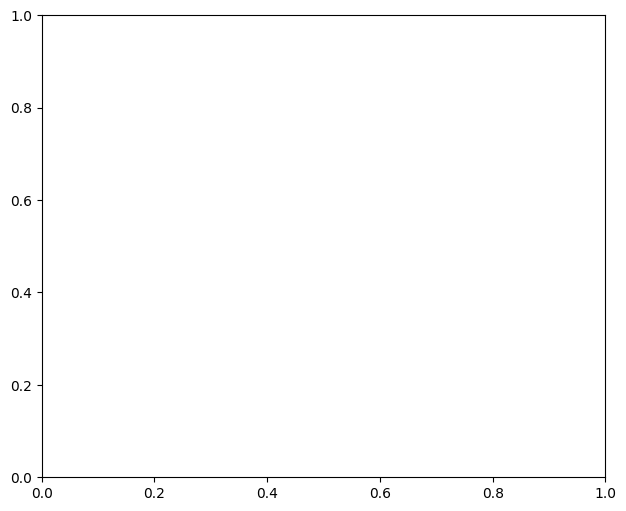

In [1]:
# ----------------------------------------
# 9. 训练过程可视化
# ----------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label='Train')
plt.plot(test_acc_hist, label='Test')
plt.title("Accuracy")
plt.legend()
plt.show()

In [2]:
# ----------------------------------------
# 10. 模型预测结果随机抽样展示
# ----------------------------------------
import random
import numpy as np

def visualize_inference(model, loader, device, num_samples=10):
    print(f"随机抽取 {num_samples} 张测试集图片进行预测对比...")
    model.eval()
    
    # 1. 从 test_loader 获取一个 batch
    # 注意：loader 已经被 shuffle=False，但我们可以手动多取几次或者直接随机
    # 为了简单，我们取第一个 batch 然后随机挑
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    # 2. 随机选择索引
    # 确保 batch size 足够，如果不够就全取
    actual_batch_size = len(images)
    if actual_batch_size < num_samples:
        indices = range(actual_batch_size)
    else:
        indices = random.sample(range(actual_batch_size), num_samples)
    
    # 类别名称
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    # 3. 绘图设置
    cols = 5
    rows = (len(indices) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3.5 * rows))
    
    for i, idx in enumerate(indices):
        # 获取单张图像数据 [T, C, H, W]
        img_tensor = images[idx] 
        label_idx = labels[idx].item()
        
        # 准备模型输入: 增加 Batch 维 -> [1, T, C, H, W] -> Permute -> [T, 1, C, H, W]
        input_tensor = img_tensor.unsqueeze(0).permute(1, 0, 2, 3, 4).to(device)
        
        # 推理
        with torch.no_grad():
            output = model(input_tensor) # [T, 1, 10]
            mean_out = output.mean(0)    # [1, 10]
            pred_idx = mean_out.argmax(1).item()
            
            functional.reset_net(model)
        
        # 可视化图像处理：
        # 将 T 帧叠加，并将 2 个通道 (ON/OFF) 合并显示
        # img_tensor shape: [T, 2, 128, 128]
        # sum(0) -> [2, 128, 128] -> sum(0) -> [128, 128] 
        # 或者分别映射到红蓝通道
        vis_img = np.zeros((128, 128, 3))
        
        # 累加所有帧
        accumulated = img_tensor.sum(dim=0).numpy() # [2, 128, 128]
        on_events = accumulated[1] # C=1 is usually ON
        off_events = accumulated[0] # C=0 is usually OFF
        
        vis_img[:, :, 0] = on_events  # Red
        vis_img[:, :, 2] = off_events # Blue
        
        # 归一化以便显示
        vis_img = np.log1p(vis_img)
        if vis_img.max() > 0:
            vis_img /= vis_img.max()
            
        # 绘制
        ax = axes.flat[i] if rows > 1 else axes[i]
        ax.imshow(vis_img, interpolation='nearest')
        
        # 标题颜色：绿色对，红色错
        color = 'green' if pred_idx == label_idx else 'red'
        title_text = f"True: {classes[label_idx]}\nPred: {classes[pred_idx]}"
        ax.set_title(title_text, color=color, fontweight='bold')
        ax.axis('off')
    
    # 隐藏多余的子图
    for j in range(i + 1, len(axes.flat)):
        axes.flat[j].axis('off')
        
    plt.tight_layout()
    plt.show()

# 执行可视化
visualize_inference(model, test_loader, DEVICE)

NameError: name 'model' is not defined